In [43]:
import os
import sys
import subprocess
import pandas as pd
from ete3 import Tree
from collections import Counter

In [44]:
ROOT_DIR = '/Volumes/AHN/captive_ape_microbiome/'

In [45]:
os.chdir(ROOT_DIR+'scripts/analyses')
%run functions.ipynb


In [31]:
#INDIR = ROOT_DIR+'results/gyrb/inputs/ps_Bacteroidales_asvRefTree'
#OUTDIR = ROOT_DIR+'results/gyrb/analyses/ps_Bacteroidales_asvRefTree'
INDIR = sys.argv[1] 
OUTDIR = sys.argv[2] 

In [32]:
tree_file = f'{INDIR}/physeq_Bacteroidales.tree'
full_tree = Tree(tree_file, format=0)

In [62]:
#inputs
metadata_file = f'{INDIR}/physeq_metadata_passing_samples.txt'
tax_table_file = f'{INDIR}/physeq_Bacteroidales_taxonomy.txt'
asv_table_file = f'{INDIR}/physeq_Bacteroidales_asv_tab.txt'
asv_fasta_file = f'{INDIR}/physeq_Bacteroidales_asv.fasta'
moeller_codiv_fasta = f'{INDIR}/moeller_codiv_Bacteroidaceae.fna'
#set blast percent identity cutoff 
pident_cutoff = 95
len_cutoff = .80

In [34]:
gyrb_asvs = asv_hr_table(asv_table_file,metadata_file,tax_table_file)
gyrb_asvs['Genus'].value_counts()[:10]

g__Prevotella            2787
g__Bacteroides            955
unclassified              534
g__Alistipes              499
g__RC9                    403
g__Porphyromonas          344
g__Bacteroides_A          322
g__Parabacteroides        294
g__Prevotellamassilia     207
g__Bacteroides_B          117
Name: Genus, dtype: int64

In [35]:
def output_summary_table(asv_hr_table_output):
     #create summary table
    Bacteroides_genera=['g__Bacteroides','g__Bacteroides_A','g__Bacteroides_B']
    all_asvs = pd.Series(asv_hr_table_output['HR_type'].value_counts(),name='ALL')
    cp_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['CP_pres']==True]['HR_type'].value_counts(),name='CP')
    Bacteroidales_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Order']=='o__Bacteroidales']['HR_type'].value_counts(),name='Bacteroidales')
    Prevotella_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus']=='g__Prevotella']['HR_type'].value_counts(),name='Prevotella')
    Bacteroides_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus'].isin(Bacteroides_genera)]['HR_type'].value_counts(),name='Bacteroides')
    Parabacteroides_asvs = pd.Series(asv_hr_table_output[asv_hr_table_output['Genus']=='g__Parabacteroides']['HR_type'].value_counts(),name='Parabacteroides')

    res = pd.concat([all_asvs,cp_asvs,Bacteroidales_asvs,
                     Prevotella_asvs,Bacteroides_asvs,Parabacteroides_asvs],
                     axis=1).fillna(0).T
    res['Total'] = res.sum(axis=1)
    res['MX_Total'] = res.loc[:,'MX_human_single_wild_ape':'MX_human_2_wild_apes'].sum(axis=1)
    return(res)  

In [36]:
gyrb_asv_summary = output_summary_table(gyrb_asvs)
print('Host restricted ASVs totals')
print(gyrb_asv_summary.loc[:,'HR_human':'HR_wild_gorilla'].sum(axis=1))
gyrb_asv_summary

Host restricted ASVs totals
ALL                7456.0
CP                   31.0
Bacteroidales      7456.0
Prevotella         2735.0
Bacteroides        1351.0
Parabacteroides     277.0
dtype: float64


,HR_human,HR_wild_bonobo,HR_wild_chimp,HR_wild_gorilla,Unique_CP,MX_human_single_wild_ape,MX_2_wild_apes,MX_human_2_wild_apes,Total,MX_Total
ALL,6683.0,378.0,257.0,138.0,96.0,33.0,6.0,5.0,7596.0,44.0
CP,27.0,0.0,4.0,0.0,96.0,10.0,0.0,2.0,139.0,12.0
Bacteroidales,6683.0,378.0,257.0,138.0,96.0,33.0,6.0,5.0,7596.0,44.0
Prevotella,2312.0,228.0,143.0,52.0,50.0,1.0,1.0,0.0,2787.0,2.0
Bacteroides,1316.0,13.0,22.0,0.0,15.0,23.0,0.0,5.0,1394.0,28.0
Parabacteroides,260.0,12.0,3.0,2.0,13.0,4.0,0.0,0.0,294.0,4.0


In [37]:
#read tree with ete3
clades_df,clades_ASVs_df = host_restricted_clades(asv_table_file,metadata_file,tax_table_file,tree_file) 


western_human        6768
non_western_human     511
wild_chimp             65
wild_gorilla           33
captive_chimp          26
wild_bonobo            24
captive_gorilla        20
captive_bonobo         12
captive_orangutan      11
Name: Description, dtype: int64


In [38]:
#host-restricted, mixed-host, and unique-to-captive clades
print(clades_df.shape)
print('numbers of clades in various host types')
print(clades_df['HR_type'].value_counts())

#Used for Figure3, where tips on tree are ASVs not clades
print(clades_ASVs_df.shape)
print('number of ASVs falling into various clades')
print(clades_ASVs_df['HR_type'].value_counts())

#Whats the breakdown of clades present in captive ape samples?
print('How many of the clades are present in captive apes?')
captive_clades = clades_df[clades_df['CP_pres']==True]
print(len(captive_clades))
print('Are these clades host-restricted, mixed host, or unique to captive?')
print(captive_clades['HR_cat'].value_counts())

#Whats the breakdown of clades present in 15% of captive ape samples of any species?
threshold=0.15
prominent_clades = clades_df.loc[(clades_df.captive_bonobo > threshold) | 
              (clades_df.captive_chimp > threshold)  |
              (clades_df.captive_gorilla > threshold)|
              (clades_df.captive_orangutan > threshold)]
print(len(prominent_clades),'captive clades in',threshold,'of captive samples of any species')
clades_df['CP_prominent'] = clades_df['cladeName'].apply(lambda x: x in list(prominent_clades['cladeName']))
clades_df_CP_prominent = clades_df[clades_df['CP_prominent']==True]
print(clades_df_CP_prominent['HR_type'].value_counts())

(358, 23)
numbers of clades in various host types
HR_human                    262
MX_human_single_wild_ape     33
HR_wild_chimp                20
HR_wild_bonobo               13
HR_wild_gorilla               9
Unique_CP                     7
MX_human_2_wild_apes          7
MX_2_wild_apes                6
MX_3_wild_apes                1
Name: HR_type, dtype: int64
(6957, 13)
number of ASVs falling into various clades
HR_human                    6146
HR_wild_bonobo               354
HR_wild_chimp                153
MX_human_single_wild_ape     110
HR_wild_gorilla               95
MX_2_wild_apes                42
MX_human_2_wild_apes          34
MX_3_wild_apes                12
Unique_CP                     11
Name: HR_type, dtype: int64
How many of the clades are present in captive apes?
52
Are these clades host-restricted, mixed host, or unique to captive?
HR           29
MX           16
Unique_CP     7
Name: HR_cat, dtype: int64
33 captive clades in 0.15 of captive samples of any speci

In [39]:
threshold = .15
clades_df['heatmap_col1'] = clades_df.apply(
    lambda row: 'MX' 
        if 'MX' in row['HR_type'] else row['HR_type'],axis=1)
clades_df['heatmap_col2'] = clades_df.apply(
    lambda row: row['heatmap_col1'] 
        if max(row['captive_bonobo':'wild_gorilla'])>.15 else 'Blank',axis=1)
clades_df['heatmap_col3'] = clades_df.apply(
    lambda row: row['heatmap_col1'] 
        if max(row['captive_bonobo':'captive_orangutan'])>.15 else 'Blank',axis=1)

### Determine ASVs that hit to Moeller co-div clades

In [60]:
subprocess.call(f'mkdir {OUTDIR}/codiv_moeller_ASVs', shell=True)
subprocess.call([f'cp {INDIR}/moeller_codiv_Bacteroidaceae.fna', 
                 f'{OUTDIR}/codiv_moeller_ASVs/moeller_codiv_Bacteroidaceae.fna'],shell=True)

#make blastdb
subprocess.call(f'makeblastdb -in {OUTDIR}/codiv_moeller_ASVs/moeller_codiv_Bacteroidaceae.fna -dbtype nucl',shell=True)

#blast moeller co-div seqs
os.system(''.join([f'blastn -query {asv_fasta_file} ',
                   f' -db {OUTDIR}/codiv_moeller_ASVs/moeller_codiv_Bacteroidaceae.fna ',
                    ' -outfmt "7 qseqid salltitles sseqid pident length qlen evalue" ',
                   f'-out {OUTDIR}/codiv_moeller_ASVs/codiv_blastout_ASVs.txt -max_target_seqs 5']))

0

In [63]:
#filter blast output to top hit per ASV, remove hits not pass thresholds
blast_res = pd.read_csv(f'{OUTDIR}/codiv_moeller_ASVs/codiv_blastout_ASVs.txt',sep='\t',comment='#',header=None)
blast_res.columns = ['ASV','codiv_clade_seq','sseqid','pident','length','qlen','evalue']
blast_res = blast_res.groupby('ASV').head(1).reset_index(drop=True) #get top hit
blast_res_pass = blast_res[blast_res['pident']>pident_cutoff].reset_index(drop=True) #QC filter
blast_res_pass = blast_res_pass[blast_res_pass['length']>(250*len_cutoff)].reset_index(drop=True) #QC filter
print(len(blast_res_pass),'ASVs matching co-div clades with greater than',pident_cutoff,'percent identity')
blast_res_pass['codiv_clade'] = blast_res_pass['codiv_clade_seq'].apply(lambda x: x.split(' ')[1])
blast_res_pass['lineage'] = blast_res_pass['codiv_clade'].apply(lambda x: x.split('_')[0]) 
blast_res_pass = blast_res_pass[['ASV','codiv_clade_seq', 'codiv_clade','lineage']]
#print(blast_res_pass.head())
print(blast_res_pass['codiv_clade'].value_counts())
#output hits passing that will be used to determine the mcra of the lineage
blast_res_pass.to_csv(f'{OUTDIR}/codiv_moeller_ASVs/codiv_clades_ASVs.txt',sep='\t',index=False)


344 ASVs matching co-div clades with greater than 95 percent identity
Bt2_clade1_bonobo     93
Bt3_clade1_human      87
Bt2_clade1_chimp      39
Bt2_clade2_bonobo     34
Bt1_clade1_bonobo     24
Bt3_clade1_chimp      18
Bt3_clade1_bonobo     15
Bt1_clade1_gorilla    11
Bt1_clade1_chimp       8
Bt2_clade1_gorilla     8
Bt2_clade2_chimp       7
Name: codiv_clade, dtype: int64


### Determine HR clades that hit to Moeller co-div clades

In [64]:
print(clades_df.shape)
clades_ASVs_codiv = clades_ASVs_df.merge(blast_res_pass, how='left', left_on='ASVs',right_on='ASV')
clades_ASVs_codiv = clades_ASVs_codiv.drop(['ASV'],axis=1)
clades_ASVs_codiv = clades_ASVs_codiv[~clades_ASVs_codiv['lineage'].isna()]
clades_ASVs_codiv = clades_ASVs_codiv[['cladeName','codiv_clade','lineage']].drop_duplicates()
clades_df_codiv = clades_df.merge(clades_ASVs_codiv, how='left',on='cladeName')
print(clades_df_codiv.groupby(['codiv_clade','lineage']).size())

(358, 27)
codiv_clade         lineage
Bt1_clade1_bonobo   Bt1         1
Bt1_clade1_chimp    Bt1         1
Bt1_clade1_gorilla  Bt1         1
Bt2_clade1_bonobo   Bt2         1
Bt2_clade1_chimp    Bt2         2
Bt2_clade1_gorilla  Bt2         1
Bt2_clade2_bonobo   Bt2         1
Bt2_clade2_chimp    Bt2         1
Bt3_clade1_bonobo   Bt3         1
Bt3_clade1_chimp    Bt3         2
Bt3_clade1_human    Bt3        17
dtype: int64


In [66]:
#Output table for Figure 2 
os.system(f'mkdir {OUTDIR}/figures')
clades_df_sh = clades_df_codiv[['cladeName', 'cladeTax', 'sampleNum', 'ASVsNum', 
      'HR_sampleTypes', 'HR_sampleNum','HR_cat', 'HR_type', 
      'CP_pres','CP_prominent', 'CP_sampleTypes', 'CP_sampleNum','captiveNames',
       'captive_bonobo', 'captive_chimp', 'captive_gorilla',
       'captive_orangutan', 'non_western_human', 'western_human',
       'wild_bonobo', 'wild_chimp', 'wild_gorilla',
       'heatmap_col1','heatmap_col2','heatmap_col3',
        'codiv_clade','lineage']]
clades_df_sh.to_csv(f'{OUTDIR}/figures/HRclades_Figure2_table.txt',sep='\t',index=False)

### search full tree for host-restricted clades

In [68]:
collasped_tree = Tree(tree_file, format=0)

def collapse_node(tree,clade_ASVs,cladeName):
    if len(clade_ASVs) > 1:
        node = tree.get_common_ancestor(clade_ASVs)
        node.name = cladeName
        children = node.get_children()
        node.remove_child(children[1])
        node.remove_child(children[0])
    else:
        ASV = clade_ASVs[0]
        leaf = tree.get_leaves_by_name(name=ASV)[0]
        leaf.name = cladeName

for clade,row in clades_df.iterrows():
    collapse_node(collasped_tree,row['ASVs'],row['cladeName'])

clade_leaves = [leaf for leaf in collasped_tree.get_leaves() if 'clade' in leaf.name] 
collasped_tree.prune(clade_leaves) #eliminate leftover ASVs and ref taxa
collasped_tree.write(format=2, outfile=f'{OUTDIR}/figures/HRclades_Figure2.tre')


### Table 2

In [80]:
Table2 = clades_df.groupby(['cladeTax','HR_type']).size().reset_index(name="count")
Table2 = Table2.pivot(index='cladeTax', columns='HR_type')['count'].fillna(0)
Table2['MX'] = Table2[['MX_2_wild_apes', 'MX_3_wild_apes',
                 'MX_human_2_wild_apes', 'MX_human_single_wild_ape']].sum(axis=1)
Table2 = Table2[['HR_human', 'HR_wild_bonobo', 'HR_wild_chimp', 
        'HR_wild_gorilla','Unique_CP', 'MX']]

nclades = int(Table2.sum(axis=1).sum())
print(nclades)
#print(Table2.sum(axis=1))
#Bacteroides_genera = ['Bacteroidaceae_Bacteroides','Bacteroidaceae_Bacteroides_A','Bacteroidaceae_Bacteroides_B']
#Bacteroides_row = pd.Series(Table2.loc[Bacteroides_genera,:].sum(),name='Bacteroidaceae_Bacteroides_combined')
#Table2 = Table2.append(Bacteroides_row).drop(Bacteroides_genera)

taxa_over_5 = Table2[Table2.sum(axis=1)>10].sum(axis=1)
print(taxa_over_5.index)
Table2_sel_genera = Table2.loc[taxa_over_5.index,:]
Table2_other_genera = pd.Series(Table2.drop(taxa_over_5.index).sum(),name='Other_genera')
Table2_sel_genera = Table2_sel_genera.append(Table2_other_genera)

Table2_sel_genera

Table2_count = Table2_sel_genera.append(pd.Series(Table2_sel_genera.sum(),name='Total'))
Table2_perc = Table2_count/Table2_sel_genera.sum()
Table2_count

358
Index(['Bacteroidaceae_Bacteroides', 'Bacteroidaceae_Bacteroides_B',
       'Bacteroidaceae_Prevotella', 'Bacteroidaceae_unclassified',
       'Porphyromonadaceae_Porphyromonas', 'Rikenellaceae_Alistipes',
       'Tannerellaceae_Parabacteroides'],
      dtype='object', name='cladeTax')


HR_type,HR_human,HR_wild_bonobo,HR_wild_chimp,HR_wild_gorilla,Unique_CP,MX
cladeTax,,,,,,
Bacteroidaceae_Bacteroides,77.0,0.0,1.0,0.0,3.0,25.0
Bacteroidaceae_Bacteroides_B,17.0,0.0,0.0,0.0,0.0,3.0
Bacteroidaceae_Prevotella,77.0,8.0,9.0,5.0,3.0,5.0
Bacteroidaceae_unclassified,5.0,3.0,2.0,1.0,0.0,2.0
Porphyromonadaceae_Porphyromonas,13.0,0.0,0.0,0.0,0.0,0.0
Rikenellaceae_Alistipes,20.0,0.0,0.0,0.0,0.0,3.0
Tannerellaceae_Parabacteroides,21.0,1.0,3.0,0.0,0.0,5.0
Other_genera,32.0,1.0,5.0,3.0,1.0,4.0
Total,262.0,13.0,20.0,9.0,7.0,47.0


### display table as a heatmap

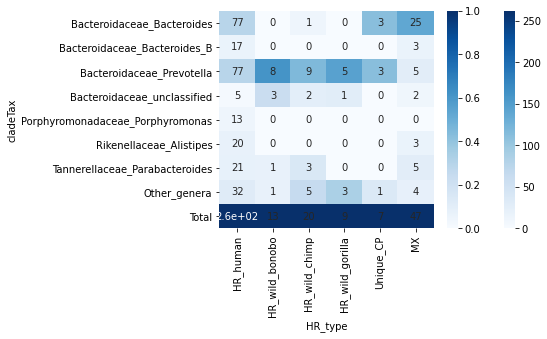

In [83]:
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.heatmap(Table2_count, annot=True, cmap="Blues")
sns.heatmap(Table2_perc, cmap="Blues")
subprocess.call(f"mkdir {OUTDIR}/tables",shell=True)
plt.savefig(f"{OUTDIR}/tables/Table2_{nclades}clades.pdf", transparent=True,bbox_inches="tight")

### Figure 3 output table

In [84]:
#taxonomic info, family and genus
tax_table = pd.read_csv(tax_table_file,sep='\t',index_col=None)
tax_table['Family'] = tax_table['Family'].apply(lambda x: 'unclassified' if 'unclassified' in x else x)
tax_table['Genus'] = tax_table['Genus'].apply(lambda x: 'unclassified' if 'unclassified' in x else x)
tax_fam_dict = dict(zip(tax_table['ASV'], tax_table['Family']))
tax_gen_dict = dict(zip(tax_table['ASV'], tax_table['Genus']))

#sample to sample type category
metadata = pd.read_csv(metadata_file,sep='\t',index_col=None)
sample_type_dict = dict(zip(metadata['X.SampleID'], metadata['Description']))

#ASV to sample names dict
asv_table = pd.read_csv(asv_table_file,sep='\t',index_col=0)
sampleNames = asv_table.apply(lambda row: list(row.index[row>0]),axis=1)
ASV_sampleName_dict = dict(zip(sampleNames.index,sampleNames))

#generate ASV dataframe 
allASVs = [leaf.name for leaf in full_tree.get_leaves() if 'ASV' in leaf.name]
allASVs = pd.DataFrame(allASVs,columns=['ASV'])
print(len(allASVs),'total ASVs')

#Host restricted clades 
#print(clades_ASVs_df.head()) 
print(len(clades_ASVs_df),'ASVs that fall into HR clades')
#Moeller codiv clades
#print(blast_res_pass.head())
print(len(blast_res_pass),'ASVs that hit greater >95% identity to codiv clade')

#combine all ASVs, HR clade info, and codiv clade info
allASVs_HRclade = allASVs.merge(clades_ASVs_df, how='left', left_on='ASV',right_on='ASVs')
allASVs_HRclade_codiv = allASVs_HRclade.merge(blast_res_pass, how='left', on='ASV')
allASVs_HRclade_codiv.head()

#add taxonomy
allASVs_HRclade_codiv['Family'] = allASVs_HRclade_codiv['ASV'].apply(lambda ASV: tax_fam_dict[ASV])
allASVs_HRclade_codiv['Genus'] = allASVs_HRclade_codiv['ASV'].apply(lambda ASV: tax_gen_dict[ASV])
print('taxonomic breakdown of ASVs')
print(allASVs_HRclade_codiv['Family'].value_counts())

#add captive sp and site description info
metadata['Description_site'] = metadata['Description']+'_' +metadata['site_code']
sample_type_site_dict = dict(zip(metadata['X.SampleID'], metadata['Description_site']))
allASVs_HRclade_codiv['sampleNames'] = allASVs_HRclade_codiv['ASV'].apply(lambda x: ASV_sampleName_dict[x])
description_df = allASVs_HRclade_codiv['sampleNames'].apply(lambda l: pd.Series(
    [sample_type_site_dict[name] for name in l]).value_counts())
description_df = description_df.fillna(0) 
description_cp_df= description_df[['captive_chimp_HOUZ','captive_gorilla_HOUZ','captive_orangutan_HOUZ',
'captive_bonobo_COLZ','captive_gorilla_COLZ','captive_orangutan_COLZ','captive_chimp_PC']]
allASVs_HRclade_codiv_cp = allASVs_HRclade_codiv.merge(description_cp_df, left_index=True,right_index=True)
allASVs_HRclade_codiv_cp['captive_all'] = allASVs_HRclade_codiv_cp.loc[:,
                        'captive_chimp_HOUZ':'captive_chimp_PC'].sum(axis=1)
print('taxonomic breakdown of ASVs found in captive apes')
print(allASVs_HRclade_codiv_cp[allASVs_HRclade_codiv_cp['captive_all']>0]['Family'].value_counts())

#add ASV HR type, 
#ind ASVs in mixed clades may be HR, also ASV not in HR clades may be HR
ASV_HR_type = gyrb_asvs[['ASV','HR_type']]
ASV_HR_type.columns = ['ASV','ASV_HR_type']
allASVs_HRclade_codiv_cp_asv = allASVs_HRclade_codiv_cp.merge(ASV_HR_type,how='left',on='ASV')
print('breakdown of HRtype for individual ASVs that dont fall into HR clades')
print(allASVs_HRclade_codiv_cp_asv[allASVs_HRclade_codiv_cp_asv['HR_cat']!='HR']['ASV_HR_type'].value_counts())
print('breakdown of HRtype for individual ASVs that dont fall into HR clades')
print(allASVs_HRclade_codiv_cp_asv[allASVs_HRclade_codiv_cp_asv['HR_cat']=='HR']['ASV_HR_type'].value_counts())
allASVs_HRclade_codiv_cp_asv = allASVs_HRclade_codiv_cp_asv.drop(columns = ['sampleNames','ASVs'])

allASVs_HRclade_codiv_cp_asv.to_csv(f'{OUTDIR}/figures/Figure3_table.txt',sep='\t',index=False)


7596 total ASVs
6957 ASVs that fall into HR clades
344 ASVs that hit greater >95% identity to codiv clade
taxonomic breakdown of ASVs
f__Bacteroidaceae        5018
f__Rikenellaceae          587
f__UBA932                 412
f__Tannerellaceae         404
f__Porphyromonadaceae     344
f__Muribaculaceae         333
f__Marinifilaceae         180
unclassified               97
f__Barnesiellaceae         75
f__Coprobacteraceae        40
f__Paludibacteraceae       34
f__Dysgonomonadaceae       32
f__UBA11471                24
f__Bacteroidaceae_A        14
f__F082                     2
Name: Family, dtype: int64
taxonomic breakdown of ASVs found in captive apes
f__Bacteroidaceae        103
f__Tannerellaceae         29
f__Porphyromonadaceae      5
f__Paludibacteraceae       1
f__Barnesiellaceae         1
Name: Family, dtype: int64
breakdown of HRtype for individual ASVs that dont fall into HR clades
HR_human                    578
HR_wild_chimp               104
Unique_CP                    52
H